Initial Drone Network:


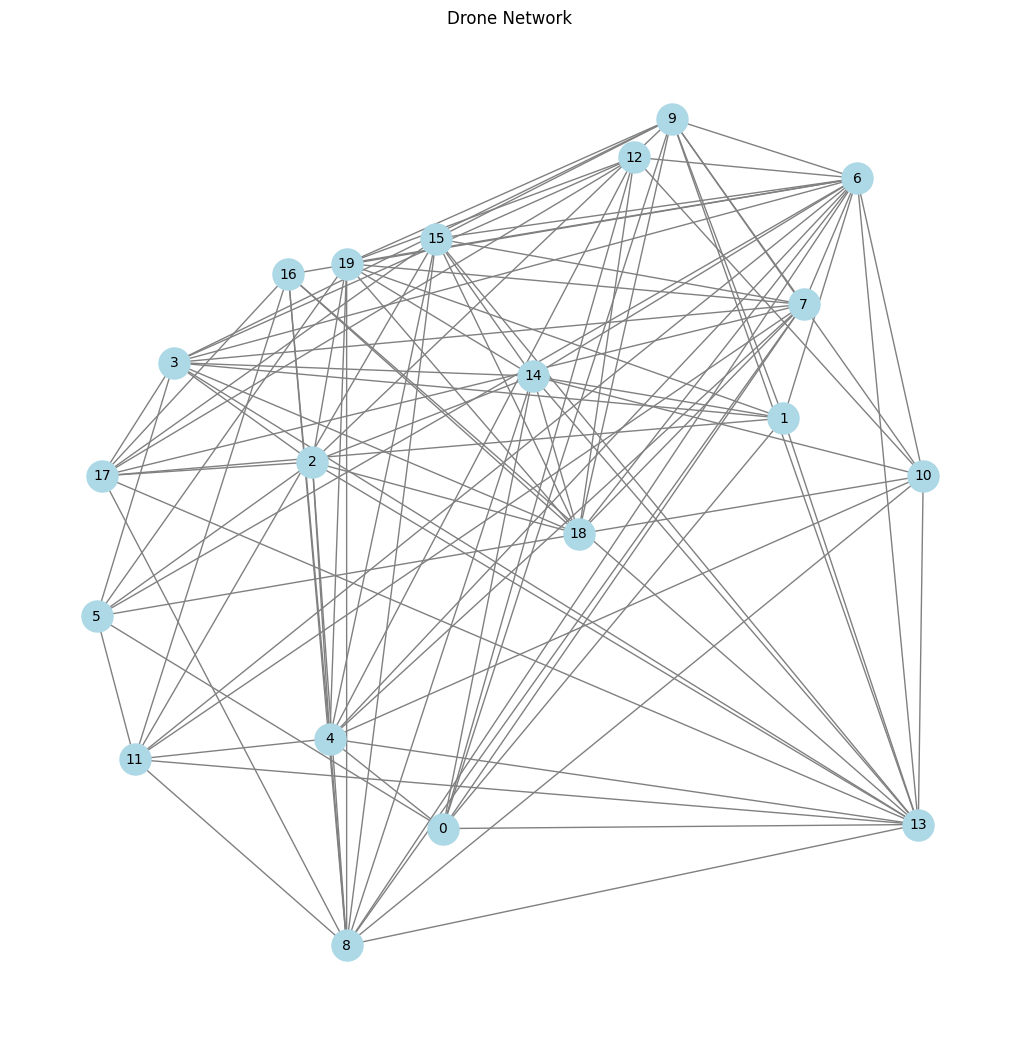

Added nodes: [20, 21, 22]
Removed nodes: [15, 12]


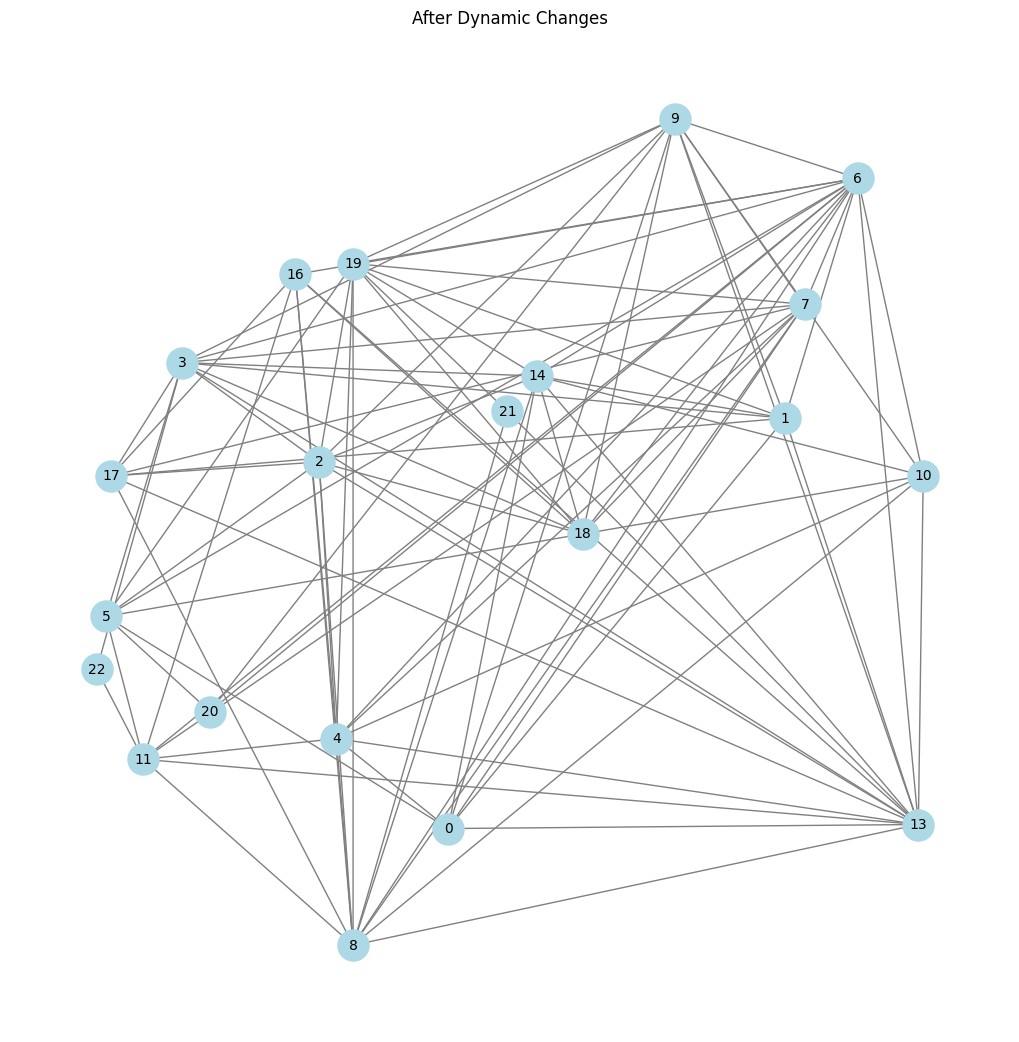

Obstacle edges removed: [(13, 17), (7, 9), (7, 17)]


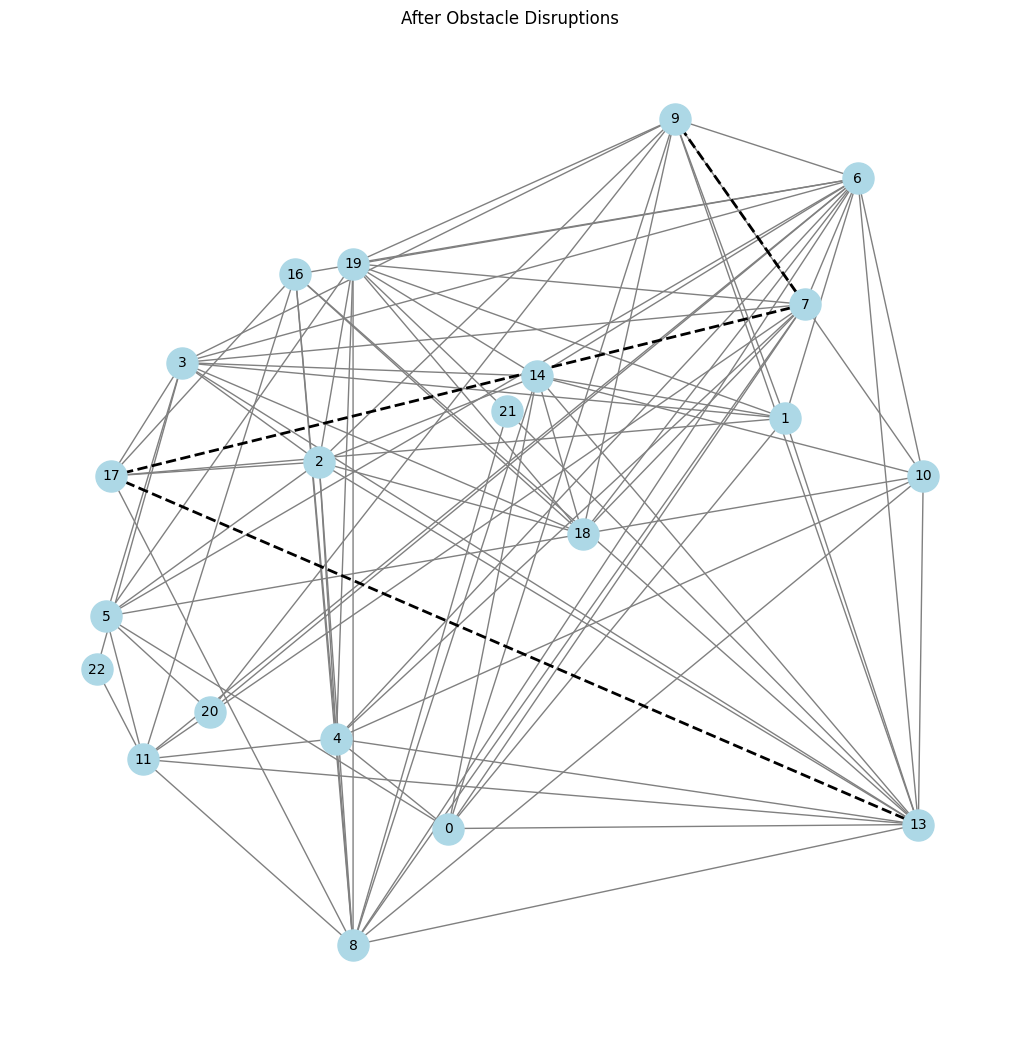

GPSR Routing:
  Path: [0, 14, 19]
  Time: 0.000046s
  Hops: 2
  Energy: 72.04328417569275


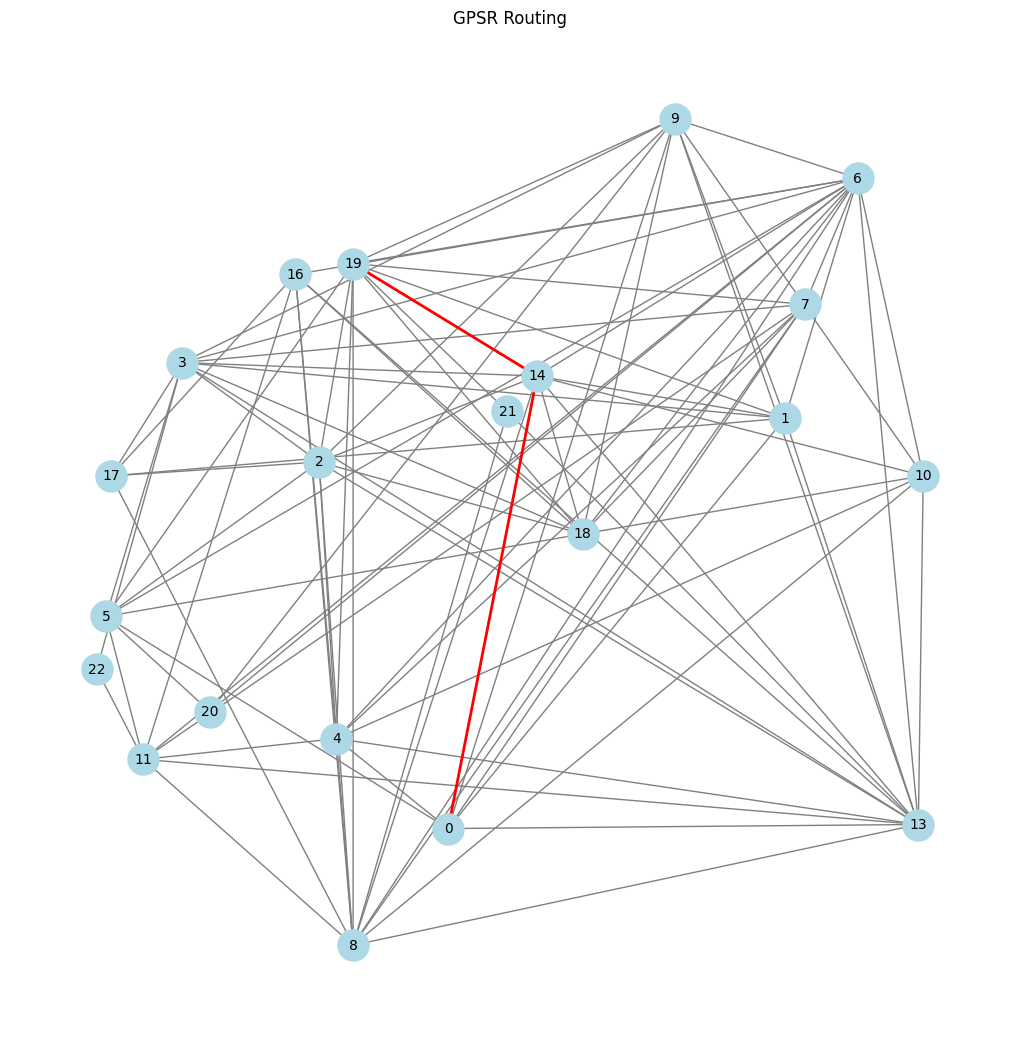

Dijkstra Routing:
  Path: [0, 4, 19]
  Time: 0.000237s
  Hops: 2
  Energy: 66.52494200192555


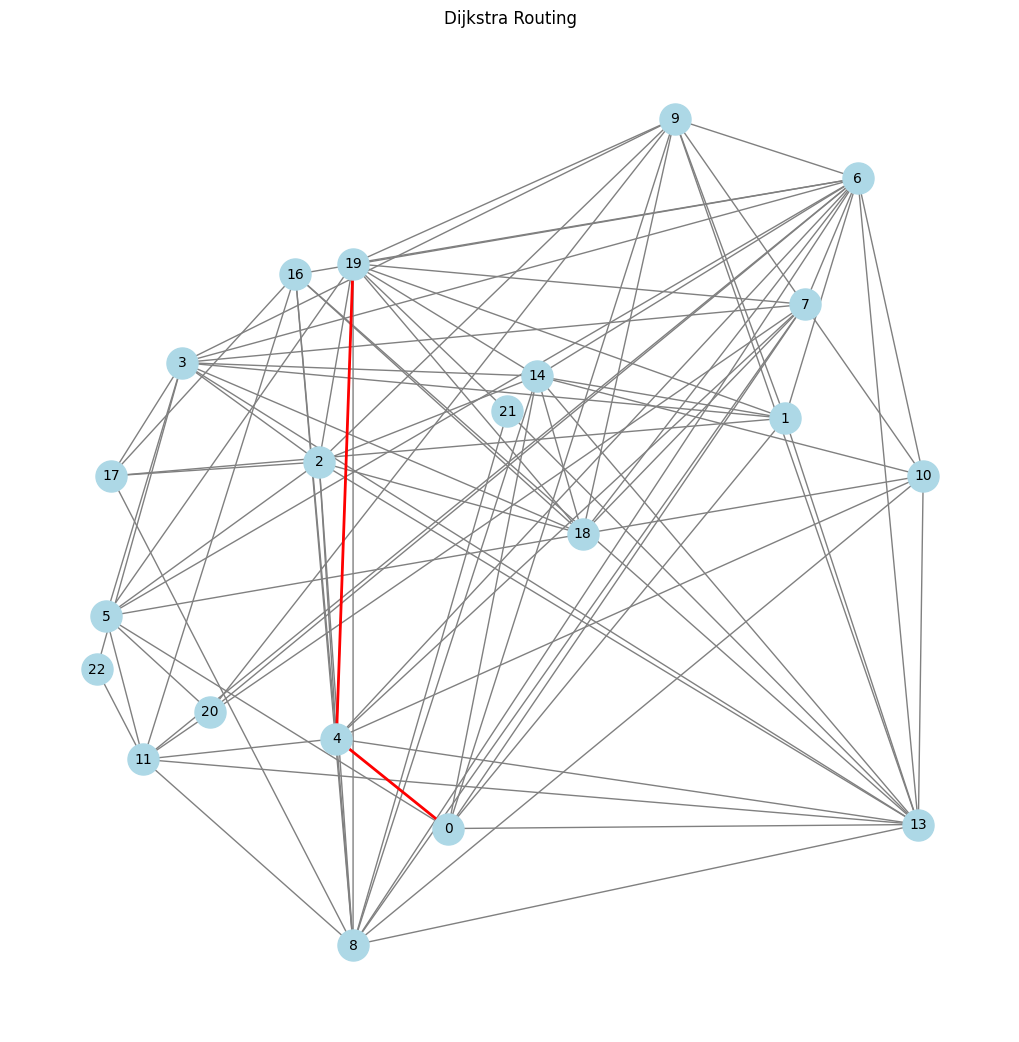

In [ ]:
import networkx as nx
import random
import math
import matplotlib.pyplot as plt
import time

# Function to generate random coordinates
def generate_coordinates(num_nodes, x_range=(0, 100), y_range=(0, 100)):
    return {i: (random.uniform(*x_range), random.uniform(*y_range)) for i in range(num_nodes)}

# Function to calculate Euclidean distance
def euclidean_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

# Create a graph with random nodes and edges
def create_drone_network(num_drones, connectivity=0.3):
    graph = nx.Graph()
    coordinates = generate_coordinates(num_drones)

    for node, coord in coordinates.items():
        graph.add_node(node, pos=coord)

    # Add edges with random connectivity
    for i in graph.nodes:
        for j in graph.nodes:
            if i != j and random.random() < connectivity:
                weight = euclidean_distance(coordinates[i], coordinates[j])
                graph.add_edge(i, j, weight=weight)

    return graph, coordinates

# GPSR Algorithm
def gpsr_routing(graph, coordinates, source, destination):
    current = source
    path = [current]

    while current != destination:
        neighbors = list(graph.neighbors(current))
        if not neighbors:
            return None  # GPSR failed, no neighbors available
        next_node = min(neighbors, key=lambda x: euclidean_distance(coordinates[x], coordinates[destination]))
        if next_node in path:  # Avoid loops
            return None
        path.append(next_node)
        current = next_node

    return path

# Dijkstra's Algorithm
def dijkstra_routing(graph, source, destination):
    try:
        return nx.shortest_path(graph, source, destination, weight='weight')
    except nx.NetworkXNoPath:
        return None  # No path exists

# Visualization function
def visualize_network(graph, coordinates, path=None, title="Drone Network", obstacles=None):
    plt.figure(figsize=(10, 10))
    pos = coordinates
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)

    if path:
        path_edges = list(zip(path, path[1:]))
        nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='red', width=2)

    if obstacles:
        nx.draw_networkx_edges(graph, pos, edgelist=obstacles, edge_color='black', width=2, style="dashed")

    plt.title(title)
    plt.show()

# Dynamic topology changes
def dynamic_changes(graph, coordinates, action="add", num_changes=1):
    nodes = list(graph.nodes)
    changes = []
    for _ in range(num_changes):
        if action == "add":
            new_node = max(graph.nodes) + 1
            new_coord = (random.uniform(0, 100), random.uniform(0, 100))
            coordinates[new_node] = new_coord
            graph.add_node(new_node, pos=new_coord)
            for _ in range(3):  # Connect to 3 random nodes
                neighbor = random.choice(nodes)
                weight = euclidean_distance(new_coord, coordinates[neighbor])
                graph.add_edge(new_node, neighbor, weight=weight)
            changes.append(new_node)
        elif action == "remove":
            if nodes:
                remove_node = random.choice(nodes)
                graph.remove_node(remove_node)
                coordinates.pop(remove_node, None)
                changes.append(remove_node)
    return changes

# Obstacle disruptions
def obstacle_disruption(graph, num_disruptions=2):
    edges = list(graph.edges)
    removed_edges = []
    for _ in range(num_disruptions):
        if edges:
            edge_to_remove = random.choice(edges)
            graph.remove_edge(*edge_to_remove)
            removed_edges.append(edge_to_remove)
    return removed_edges

# Performance evaluation
def evaluate_routing(graph, coordinates, source, destination):
    results = {}

    # GPSR Routing
    start = time.time()
    gpsr_path = gpsr_routing(graph, coordinates, source, destination)
    gpsr_time = time.time() - start
    if gpsr_path:
        gpsr_hops = len(gpsr_path) - 1
        gpsr_energy = sum(graph.edges[edge]['weight'] for edge in zip(gpsr_path, gpsr_path[1:]))
    else:
        gpsr_hops = None
        gpsr_energy = None

    results["GPSR"] = {
        "path": gpsr_path,
        "time": gpsr_time,
        "hops": gpsr_hops,
        "energy": gpsr_energy,
    }

    # Dijkstra's Routing
    start = time.time()
    dijkstra_path = dijkstra_routing(graph, source, destination)
    dijkstra_time = time.time() - start
    if dijkstra_path:
        dijkstra_hops = len(dijkstra_path) - 1
        dijkstra_energy = sum(graph.edges[edge]['weight'] for edge in zip(dijkstra_path, dijkstra_path[1:]))
    else:
        dijkstra_hops = None
        dijkstra_energy = None

    results["Dijkstra"] = {
        "path": dijkstra_path,
        "time": dijkstra_time,
        "hops": dijkstra_hops,
        "energy": dijkstra_energy,
    }

    return results

# Main Simulation
def main():
    num_drones = 20
    graph, coordinates = create_drone_network(num_drones)

    print("Initial Drone Network:")
    visualize_network(graph, coordinates)

    # Dynamic changes
    added_nodes = dynamic_changes(graph, coordinates, action="add", num_changes=3)
    removed_nodes = dynamic_changes(graph, coordinates, action="remove", num_changes=2)
    print(f"Added nodes: {added_nodes}")
    print(f"Removed nodes: {removed_nodes}")
    visualize_network(graph, coordinates, title="After Dynamic Changes")

    # Obstacle disruptions
    removed_edges = obstacle_disruption(graph, num_disruptions=3)
    print(f"Obstacle edges removed: {removed_edges}")
    visualize_network(graph, coordinates, obstacles=removed_edges, title="After Obstacle Disruptions")

    # Routing example
    source, destination = 0, num_drones - 1

    # Ensure source and destination exist
    if source not in graph.nodes or destination not in graph.nodes:
        print(f"Error: Source ({source}) or destination ({destination}) node is not in the graph.")
        return

    results = evaluate_routing(graph, coordinates, source, destination)

    for protocol, result in results.items():
        print(f"{protocol} Routing:")
        print(f"  Path: {result['path']}")
        print(f"  Time: {result['time']:.6f}s")
        print(f"  Hops: {result['hops']}")
        print(f"  Energy: {result['energy']}")
        if result["path"]:
            visualize_network(graph, coordinates, path=result["path"], title=f"{protocol} Routing")

if __name__ == "__main__":
    graph, coordinates = create_drone_network(num_drones=20)  # Create the graph
    main_graph = graph  # Assign to a global variable for later use
    main_coordinates = coordinates  # Assign to a global variable for later use
    main()  # Run the simulation


In [ ]:
# Additional metrics: Success Rate and Overhead Analysis
def additional_metrics(graph, coordinates, num_trials=50):
    success_count_gpsr = 0
    total_hops_gpsr = 0
    total_hops_dijkstra = 0
    total_energy_gpsr = 0
    total_energy_dijkstra = 0

    source_nodes = list(graph.nodes)
    results = []

    for _ in range(num_trials):
        # Select random source and destination nodes
        source, destination = random.sample(source_nodes, 2)

        # GPSR Routing
        gpsr_path = gpsr_routing(graph, coordinates, source, destination)
        if gpsr_path:
            success_count_gpsr += 1
            gpsr_hops = len(gpsr_path) - 1
            gpsr_energy = sum(graph.edges[edge]['weight'] for edge in zip(gpsr_path, gpsr_path[1:]))
            total_hops_gpsr += gpsr_hops
            total_energy_gpsr += gpsr_energy

        # Dijkstra's Routing
        dijkstra_path = dijkstra_routing(graph, source, destination)
        if dijkstra_path:
            dijkstra_hops = len(dijkstra_path) - 1
            dijkstra_energy = sum(graph.edges[edge]['weight'] for edge in zip(dijkstra_path, dijkstra_path[1:]))
            total_hops_dijkstra += dijkstra_hops
            total_energy_dijkstra += dijkstra_energy

    # Calculate metrics
    success_rate_gpsr = success_count_gpsr / num_trials * 100
    avg_hops_gpsr = total_hops_gpsr / success_count_gpsr if success_count_gpsr > 0 else None
    avg_hops_dijkstra = total_hops_dijkstra / num_trials
    avg_energy_gpsr = total_energy_gpsr / success_count_gpsr if success_count_gpsr > 0 else None
    avg_energy_dijkstra = total_energy_dijkstra / num_trials

    results.append({
        "success_rate_gpsr": success_rate_gpsr,
        "avg_hops_gpsr": avg_hops_gpsr,
        "avg_hops_dijkstra": avg_hops_dijkstra,
        "avg_energy_gpsr": avg_energy_gpsr,
        "avg_energy_dijkstra": avg_energy_dijkstra,
    })

    return results

# Execute additional metrics evaluation
additional_results = additional_metrics(graph, coordinates)
print("Additional Metrics:")
for result in additional_results:
    print(f"GPSR Success Rate: {result['success_rate_gpsr']:.2f}%")
    print(f"Average Hops (GPSR): {result['avg_hops_gpsr']}")
    print(f"Average Hops (Dijkstra): {result['avg_hops_dijkstra']:.2f}")
    print(f"Average Energy (GPSR): {result['avg_energy_gpsr']}")
    print(f"Average Energy (Dijkstra): {result['avg_energy_dijkstra']:.2f}")

Additional Metrics:
GPSR Success Rate: 90.00%
Average Hops (GPSR): 1.711111111111111
Average Hops (Dijkstra): 1.58
Average Energy (GPSR): 67.01208005216101
Average Energy (Dijkstra): 62.90
